In [120]:
# import custom and regular modules
import sys
%load_ext autoreload
%autoreload 2
if "../src" not in sys.path: sys.path.append("../src")

from df_info_str import df_info_str
import pandas as pd
import os
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 60
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["axes.labelsize"] = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
## read in custatts_skeylevel

custs = pd.read_csv("../data_transformed/email_customers/"
    "custatts_skeylvl_20190701to20190831.csv")

print("\ndf_info_str(custs):\n\n" + df_info_str(custs))


df_info_str(custs):

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281425 entries, 0 to 281424
Data columns (total 10 columns):
subkey               281425 non-null object
visits_vid_live      281425 non-null int64
visits_vid_fer       281425 non-null int64
visits_vid_hl        281425 non-null int64
visits_vid_eng       281425 non-null int64
visits_ed            281425 non-null int64
visits               281425 non-null int64
pianoid              20094 non-null object
emailopens           281425 non-null float64
emailopens_bucket    281425 non-null object
dtypes: float64(1), int64(6), object(3)
memory usage: 21.5+ MB
head():
                                 subkey  visits_vid_live  visits_vid_fer  \
0  000018a2-84d4-40ca-a942-f7224f246357                0               0   
1  000031d2-05bc-4b8f-b5a9-ae4327dba079                0               0   
2  00006416-4c39-4147-8d25-0b10a78b3783                0               0   
3  0000bb76-deed-4834-a9b1-70d9801e1d34           

In [122]:
## fix emailopens_bucket values

if "(" in custs["emailopens_bucket"].iloc[0]:
    
    # get the bucket vals
    bs = custs["emailopens_bucket"].drop_duplicates().values

    # get the start and end of each bucket
    def getbuckstart(b):
        return int(b[b.index("(") + 1 : b.index(",")]) + 1
    def getbuckend(b):
        return int(b[b.index(", ") + 2 : b.index("]")])
    b_starts = list(map(getbuckstart, bs))
    b_ends = list(map(getbuckend, bs))

    # sort by b_starts
    bs = [x for _, x  in sorted(zip(b_starts, bs))]
    b_ends = [x for _, x  in sorted(zip(b_starts, b_ends))]
    b_starts = list(sorted(b_starts))

    # get new buckets
    bs_new = list(map(lambda bvals: str(bvals[0]) + "-" + str(bvals[1]),
        zip(b_starts, b_ends)
        ))

    # fix last bucket
    bs_new[-1] = "> " + str(b_starts[-1] - 1)

    # create mapping
    bucks_old_to_new = dict(zip(bs, bs_new))

    # map old buckets to new
    custs["emailopens_bucket"] = custs["emailopens_bucket"].map(
        bucks_old_to_new)

# print new bucket vals
print("\ncusts['emailopens_bucket'].value_counts():\n"
    + str(custs["emailopens_bucket"].value_counts().sort_index()))


custs['emailopens_bucket'].value_counts():
0-10     99141
11-20    47030
21-50    64745
> 50     70509
Name: emailopens_bucket, dtype: int64


In [123]:
## series to bar chart function

def plot_series_bar(ser, xlabel=None, ylabel=None, color="gold", rot=0,
    ylim = (None, None)):
    
    # plot
    plt.figure()
    ax = ser.plot(kind="bar", color=color, rot=rot)
    
    # axis labels
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    # ylim
    ax.set_ylim(ylim)
    
    # make yticklabels readable
    yticks = list(map(int, ax.get_yticks().tolist()))
    if max(yticks) > 10**5:
        ax.set_yticklabels([
            ('{:,}'.format(int(x)) if int(x) >= 1000 else x) 
            for x in yticks
            ])
    
    # tight layout
    plt.tight_layout()

In [124]:
## function that computes the probability of revisiting for a customer group

def get_revisit_prob(custs, visitcol):
    revprob = (custs[visitcol] >= 2).sum() / (custs[visitcol] >= 1).sum()
    return revprob

# demo
print("\nget_revisit_prob(custs, 'visits') = " 
      + str(get_revisit_prob(custs, 'visits')))


get_revisit_prob(custs, 'visits') = 0.7825317580172337



len(custs_foc) = 1242

revprob_mean = 0.46

emailopens_mean = 26.09


<IPython.core.display.Javascript object>


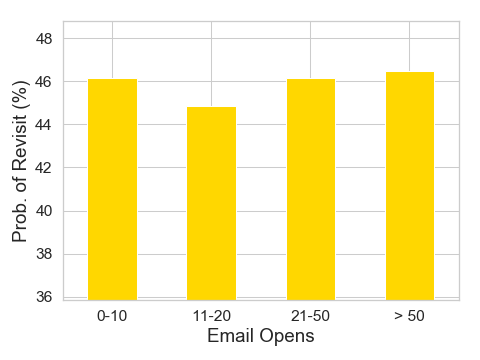

In [180]:
## VISITS REVPROB for non-gold custs by OPEN BUCKETS

# specifying content format
visitcol = "visits_vid_live"

# focusing on customers subset
custs_foc = custs[
    custs["pianoid"].isnull()
    & (custs[visitcol] > 0)
    ]
print("\nlen(custs_foc) = " + str(len(custs_foc)))

# compute mean revprob and emailopens
revprob_mean = get_revisit_prob(custs_foc, visitcol)
print("\nrevprob_mean = " + str(round(revprob_mean, 2)))
print("\nemailopens_mean = " + str(round(custs_foc["emailopens"].mean(), 2)))

# compute revprob by opensbucket
revprobs = custs_foc.groupby("emailopens_bucket").apply(
    lambda df: get_revisit_prob(df, visitcol))
revprobs = revprobs * 100
ylabel = "Prob. of Revisit (%)"
xlabel = "Email Opens"
plot_series_bar(revprobs, xlabel=xlabel, ylabel=ylabel, 
    ylim=(0.8*revprobs.min(), None))

In [156]:
## computing the slope of the revprob bar plot

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# getting the mean email opens in each bucket
emopenmeans = custs_foc.groupby("emailopens_bucket")["emailopens"].mean()

# getting slope of linear fit
model = LinearRegression()

xs = emopenmeans[None:-1]
xs_mean = custs_foc[
    custs_foc["emailopens"] <= 50]["emailopens"].mean()
xs = xs / xs_mean * 100
ys = revprobs[None:-1]

model.fit(xs.values.reshape(-1, 1), ys.values.reshape(-1, 1))
model.coef_[0][0]

0.12721351145162652


visits_vid_live_mean = 2.41

visits_by_opensbuck:
emailopens_bucket
0-10     2.473968
11-20    2.364532
21-50    2.221831
> 50     2.555556
Name: visits_vid_live, dtype: float64


<IPython.core.display.Javascript object>


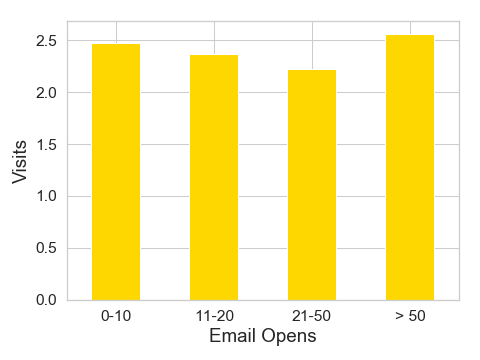

In [178]:
## VISITS for non-gold custs by OPENS BUCKETS

# specifying content format
visitcol = "visits_vid_live"

# focusing on customers subset
custs_foc = custs[
    custs["pianoid"].isnull()
    & (custs[visitcol] > 0)
    ]

# compute mean visits
print("\n" + visitcol + "_mean = " + str(round(custs_foc[visitcol].mean(), 
    2)))

# compute
visits_by_opensbuck = custs_foc.groupby("emailopens_bucket")[visitcol].mean()
print("\nvisits_by_opensbuck:\n" + str(visits_by_opensbuck))
ylabel = "Visits"
xlabel = "Email Opens"
plot_series_bar(visits_by_opensbuck, xlabel=xlabel, ylabel=ylabel)

In [158]:
## computing the slope of the visits bar plot

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# getting the mean email opens in each bucket
emopenmeans = custs_foc.groupby("emailopens_bucket")["emailopens"].mean()

# getting slope of linear fit
model = LinearRegression()

xs = custs_foc["emailopens"] / custs_foc["emailopens"].mean()
ys = custs_foc[visitcol] / custs_foc[visitcol].mean()

# xs = emopenmeans[None:-1]
# xs_mean = custs_foc[
#     custs_foc["emailopens"] <= 50]["emailopens"].mean()
# xs = xs / xs_mean * 100
# ys = revprobs[None:-1]

model.fit(xs.values.reshape(-1, 1), ys.values.reshape(-1, 1))
model.coef_[0][0]

0.149425122640573

In [159]:
# gold v non-gold customers
custs.groupby(custs["pianoid"].notnull())["subkey"].count()

pianoid
False    261331
True      20094
Name: subkey, dtype: int64

In [169]:
# visits openers v non-openers
visitcol = "visits"
custs_foc = custs[
    custs["pianoid"].isnull()
    & (custs[visitcol] > 0)
    ]
custs_foc.groupby(custs["emailopens"] > 0)[visitcol].mean()

emailopens
False    4.525865
True     7.312677
Name: visits, dtype: float64

In [172]:
# visits by format

vidvisitcols = custs.columns[custs.columns.str.startswith("visits_vid")]
visitfracs_by_vidformat = custs[vidvisitcols].sum()\
    / custs[vidvisitcols].sum().sum()
visitfracs_by_vidformat

visits_vid_live    0.028217
visits_vid_fer     0.001171
visits_vid_hl      0.962412
visits_vid_eng     0.008200
dtype: float64

In [182]:
# visits by sport

custs_datelvl = pd.read_csv("../data_transformed/email_customers/"
    "custatts_dateskeylvl.csv")

sport
baseball              1569
basketball             256
cycling                 31
esports                  6
football                91
golf                  3670
gymnastics              47
hockey                1818
horse_racing           116
lacrosse                 1
motor_sports           983
olympics               298
soccer                1671
swimming                18
tennis                 124
track_and_field         29
unknown            4368501
Name: visits, dtype: int64

In [188]:

visits_by_sport = custs_datelvl.groupby("sport")["visits"].sum().drop(["unknown"]).sort_values()
visitfracs_by_sport = visits_by_sport / visits_by_sport.sum()

visitfracs_by_sport

sport
lacrosse           0.000093
esports            0.000559
swimming           0.001678
track_and_field    0.002703
cycling            0.002890
gymnastics         0.004381
football           0.008482
horse_racing       0.010813
tennis             0.011559
basketball         0.023863
olympics           0.027778
motor_sports       0.091629
baseball           0.146253
soccer             0.155761
hockey             0.169463
golf               0.342095
Name: visits, dtype: float64